In [52]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.linear_model import LinearRegression
pd.set_option('display.max_columns',100)

### READING THE FILE

In [2]:
csv_file_path = 'data.csv'  # Replace with your CSV file path
df = pd.read_csv(csv_file_path)

### TYPE CASTING THE START AND END TIME COLUMNS TO DATETIME FORMAT

In [22]:
df['Start Time'] = pd.to_datetime(df['Start Time'], format='%Y-%m-%dT%H:%M:%S')
df['End Time'] = pd.to_datetime(df['End Time'], format='%Y-%m-%dT%H:%M:%S')

In [23]:
df['Vessel Name'].value_counts()

Vessel Name
Vessel 1    105120
Vessel 2    105120
Name: count, dtype: int64

In [24]:
df1 = df[df['Vessel Name']=='Vessel 1']
df2 = df[df['Vessel Name']=='Vessel 1']

### VESSEL 1

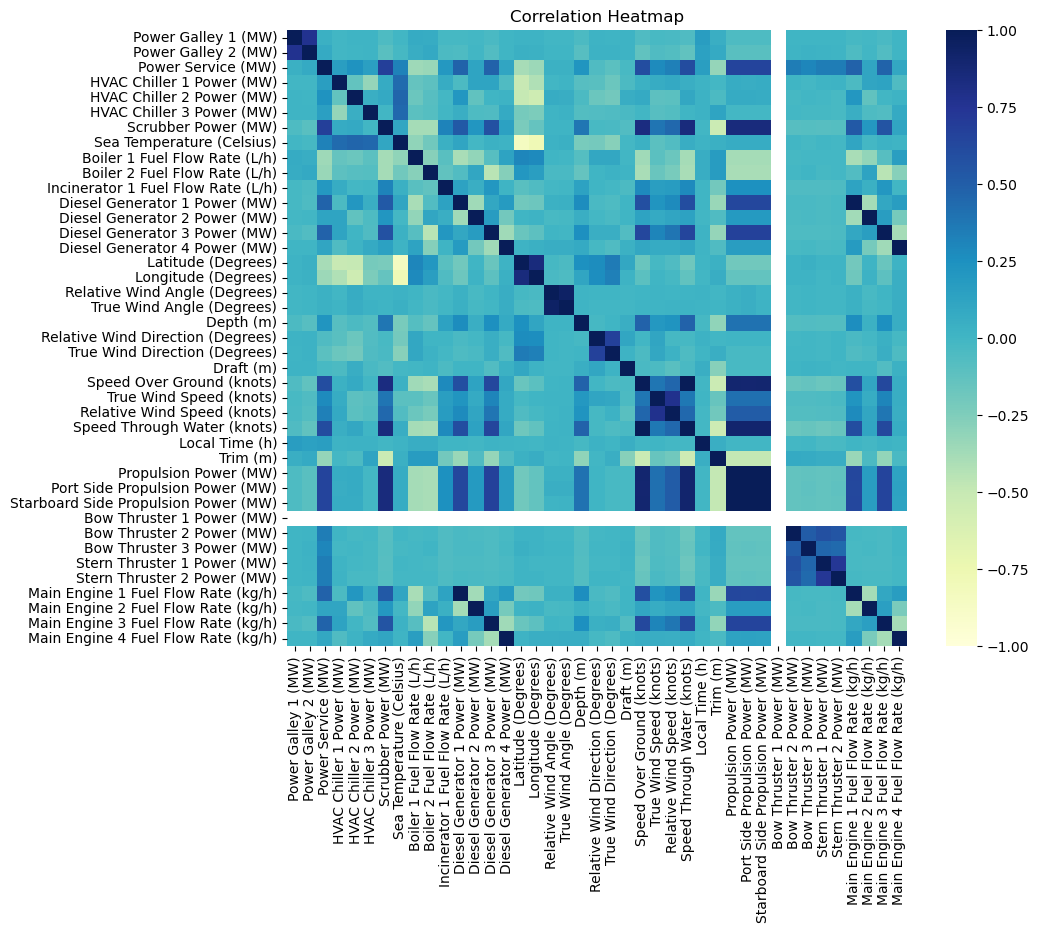

In [71]:
df_correlation = df1.corr(method='pearson', numeric_only=True)
df_correlation
     
plt.figure(figsize=(10, 8))
sns.heatmap(df_correlation, annot=False, cmap='YlGnBu', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

#### FIXING NULL VALUES

In [59]:
df1.isnull().sum()

Start Time                                  0
End Time                                    0
Vessel Name                                 0
Power Galley 1 (MW)                         0
Power Galley 2 (MW)                         0
Power Service (MW)                          0
HVAC Chiller 1 Power (MW)                   0
HVAC Chiller 2 Power (MW)                   0
HVAC Chiller 3 Power (MW)                   0
Scrubber Power (MW)                         0
Sea Temperature (Celsius)                   0
Boiler 1 Fuel Flow Rate (L/h)               0
Boiler 2 Fuel Flow Rate (L/h)               0
Incinerator 1 Fuel Flow Rate (L/h)          0
Diesel Generator 1 Power (MW)               0
Diesel Generator 2 Power (MW)               0
Diesel Generator 3 Power (MW)               0
Diesel Generator 4 Power (MW)               0
Latitude (Degrees)                          0
Longitude (Degrees)                         0
Relative Wind Angle (Degrees)               0
True Wind Angle (Degrees)         

In [46]:
df1 = df1.dropna(subset=['Power Galley 1 (MW)'])

#Wherever speed over ground is 0 and True Wind Angle (Degrees) is null, filling it with Relative Wind Angle (Degrees)
df1['True Wind Angle (Degrees)'] = np.where(df1['True Wind Angle (Degrees)'].isnull(), df1['Relative Wind Angle (Degrees)'], df1['True Wind Angle (Degrees)'])
df1['True Wind Speed (knots)'] = np.where(df1['True Wind Speed (knots)'].isnull(), df1['Relative Wind Speed (knots)'], df1['True Wind Speed (knots)'])

### USING LINEAR REGRESSION TO IMPUTE NULL VALUES FOR SPEED THROUGH WATER LOOKING AT THE CORRELATION

In [58]:
df1_non_missing = df1[df1['Speed Through Water (knots)'].notnull()]
df1_missing = df1[df1['Speed Through Water (knots)'].isnull()]

# Train a linear regression model using non-missing values
X = df1_non_missing[['Scrubber Power (MW)', 'Speed Over Ground (knots)', 'Propulsion Power (MW)']]  # Predictor (SOG)
y = df1_non_missing['Speed Through Water (knots)']  # Target (STW)

model = LinearRegression()
model.fit(X, y)

# Predict the missing STW values using the SOG values
predicted_stw = model.predict(df1_missing[['Scrubber Power (MW)', 'Speed Over Ground (knots)', 'Propulsion Power (MW)']])

# Impute the missing values
df1.loc[df1['Speed Through Water (knots)'].isnull(), 'Speed Through Water (knots)'] = predicted_stw


In [73]:
df1.to_excel('vessel1_data.xlsx', index = False)